<a href="https://colab.research.google.com/github/ekingit/CNN-for-CIFAR10/blob/main/pretrained_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import datasets
from torchvision.transforms import v2

#Data

In [2]:
mu = torch.tensor([0.485, 0.456, 0.406]) #  (3)
sigma = torch.tensor([0.229, 0.224, 0.225]) # (3)

v2_train = v2.Compose([v2.ToImage(), v2.Resize(224), v2.ToDtype(torch.float32, scale=True), v2.Normalize(mu, sigma),])
v2_test = v2.Compose([v2.ToImage(), v2.Resize(224), v2.ToDtype(torch.float32, scale=True), v2.Normalize(mu, sigma),])

In [3]:
ds_train = datasets.CIFAR10('./data', train=True, download=True, transform=v2_train)
ds_test = datasets.CIFAR10('./data', train=False, download=True, transform=v2_test)
dl_train = DataLoader(ds_train, batch_size=32,shuffle=True) #50.000 item = 128*390.625 = 128*390+80
dl_test = DataLoader(ds_test, batch_size=32,shuffle=True) #10.000 item = 128*78.125 = 128*78+16

Files already downloaded and verified
Files already downloaded and verified


#Model

In [4]:
pretrained_model = torchvision.models.vit_b_16('IMAGENET1K_V1')

total_parameters = sum(p.numel() for p in pretrained_model.parameters())
print(f"Total Parameters: {total_parameters}") #12 million parameters

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Total Parameters: 86567656


In [5]:
for name, layer in pretrained_model.named_children():
    print(name, layer)

conv_proj Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
encoder Encoder(
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=3072, out_features=768, bias=True)
        (4): Dropout(p=0.0, inplace=False)
      )
    )
    (encoder_layer_1): EncoderBlock(
      (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuan

In [6]:
pretrained_model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [7]:
pretrained_model.heads = nn.Sequential(
    nn.Linear(768, 10)
)

In [8]:
def train(model, dl, optimizer, epoch, device='cpu'):
    model.to(device)
    model.train() #from nn.Module
    correct = 0
    train_loss = 0
    for data, target in dl:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data) #(batch_size,3,32,32) --> (10)
        batch_loss = loss(output, target) #(10x10) --> 1
        batch_loss.backward() #calculates gradients
        optimizer.step() #updates weights and kernels
        train_loss += batch_loss.detach().item()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    correct = 100. * correct / len(dl.dataset)
    train_loss /= len(dl)
    trainloss.append(train_loss)
    trainacc.append(correct)
    print(f'Epoch: {epoch}, Avarage train loss: {train_loss:.2f}, Accuracy: {correct:.1f}%')

In [9]:
def test(model, dl_test, device='cpu'):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # no need to track gradients. Saves memory.
        for data, target in dl_test:
            data, target = data.to(device), target.to(device)
            output = model(data)
            batch_loss = loss(output,target)
            test_loss += batch_loss.detach().item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # get the correct predictions

    test_loss /= len(dl_test)
    correct = 100. * correct / len(dl_test.dataset)
    testloss.append(test_loss)
    testacc.append(correct)
    print(f'Avarage test loss: {test_loss:.2f}, Accuracy: {correct:.1f}%')

#Train

In [10]:
#Run with A100-GPU
lr = 5e-5
momentum = 0.9
weight_decay = 5e-5
epochs = 5

torch.manual_seed(4321) #fixes initial weights and kernels to test different models/hyperparameters

device = 'cuda'
if device == 'cuda': torch.backends.cudnn.benchmark = True # additional speed up

params = [param for name, param in pretrained_model.named_parameters() if name not in ["heads.0.weight", "heads.0.bias"]] # all params except the last layer

optimizer = torch.optim.SGD([{'params': params}, {'params': pretrained_model.heads.parameters(), 'lr': 10 * lr}], lr=lr, momentum=momentum, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

loss = nn.CrossEntropyLoss()

# run()
a = time.time()
trainloss = []
testloss = []
trainacc = []
testacc = []

for epoch in range(0, epochs):
    train(pretrained_model, dl_train, optimizer, epoch+1, device=device)
    test(pretrained_model, dl_test, device=device)
    scheduler.step()

b = time.time()
print(f'Training took {round(b - a, 0)} seconds.')

Epoch: 1, Avarage train loss: 0.28, Accuracy: 93.3%
Avarage test loss: 0.12, Accuracy: 96.3%
Epoch: 2, Avarage train loss: 0.10, Accuracy: 96.9%
Avarage test loss: 0.10, Accuracy: 96.8%
Epoch: 3, Avarage train loss: 0.07, Accuracy: 97.8%
Avarage test loss: 0.09, Accuracy: 97.0%
Epoch: 4, Avarage train loss: 0.06, Accuracy: 98.3%
Avarage test loss: 0.08, Accuracy: 97.4%
Epoch: 5, Avarage train loss: 0.04, Accuracy: 98.7%
Avarage test loss: 0.08, Accuracy: 97.3%
Training took 2230.0 seconds.


In [11]:
ds_test_2 = datasets.CIFAR10('./data', train=False, download=True)

Files already downloaded and verified


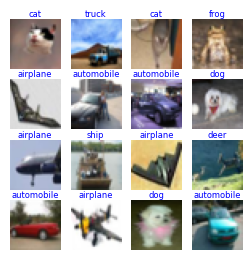

In [12]:
#looking at the predictions
labels = {0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
rand = torch.randint(10000,(16,1))
fig, ax = plt.subplots(4,4,figsize=(3,3))
for i, c_ax in enumerate(ax.flatten()):
    ex_num = rand[i].item()
    var1 = ds_test[ex_num][0].reshape(1,3,224,224)
    var1 = var1.to(device)
    var2 = (ds_test_2[ex_num][0])
    im = (ds_test[ex_num][1])
    pred = pretrained_model(var1)
    pred = pred.argmax(dim=1, keepdim=True)
    lab = pred.item()
    if ds_test[ex_num][1] == pred:
        c_ax.set_title((labels[lab]),fontsize=6,color='blue', y=0.88)
    else:
        c_ax.set_title(labels[lab],fontsize=6,color='red', y=0.88)
    c_ax.imshow(var2)
    c_ax.axis('off')